## Physics Informed Neural Networks to Approximate Solution of PDEs

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append('/Users/timostroschein/Desktop/Deep Learning/DLSC')
#from Common import NeuralNet, MultiVariatePoly
from drive.MyDrive.DLSC.Common import NeuralNet, MultiVariatePoly
import time
import pandas as pd
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)


In [24]:
dev = 'cuda:0' #'mps'  or 'cuda:0'

device =torch.device(dev)
torch.set_default_device(dev)

In [25]:
from google.colab import files
uploaded = files.upload()

Saving SubExample.txt to SubExample.txt


In [26]:
alpha_f = 0.05; alpha_s= 0.08 ;h_f =5 ;h_s = 6 ; T_hot = 4; T0 = 1;  U_f =1

#Hyperparams
Lambda = 3; Hidden_layers=4; Neurons=20;

#Training optimizer
Adam_opt = False; n_epochs_A = 1000
LBFGS_opt = True; n_epochs_L = 2

In [27]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        self.Final_loss = None;

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = Lambda

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=2,
                                              n_hidden_layers=Hidden_layers,
                                              neurons=Neurons,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        tens = tens.to(device)
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, batch_size):
        return torch.full((batch_size,2), T0) #torch.full((self.n_tb,2), T0)

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(self.n_tb)

        return input_tb, output_tb

    def boundary_x0_for_Tf(self, t):
        return ((T_hot-T0)/(1+ torch.exp(-200* (t -0.25))) + T0).view(-1,1)

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        Tf_sb_0 = self.boundary_x0_for_Tf(input_sb_0[:,0])

        output_sb_0 = torch.cat([ Tf_sb_0,torch.zeros((input_sb.shape[0], 1))], 1)
        output_sb_L = torch.zeros((input_sb.shape[0], 2))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 2))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        l = int(input_sb.shape[0]/2)

        input_sb.requires_grad = True
        u_pred_sb = self.approximate_solution(input_sb)

        Tf=u_pred_sb[:,0].view(-1,1)
        Ts=u_pred_sb[:,1].view(-1,1)

        grad_Ts= torch.autograd.grad(Ts.sum(), input_sb, create_graph=True)[0]
        grad_Ts_x = grad_Ts[:, 1].view(-1,1)

        l = int(input_sb.shape[0]/2)
        grad_Tf= torch.autograd.grad(Tf.sum(), input_sb, create_graph=True)[0]
        grad_Tf_x = grad_Tf[l:, 1].view(-1,1)

        boundary_0 = torch.cat([Tf[:l].view(-1,1),grad_Ts_x[:l]],1)
        boundary_L = torch.cat([grad_Tf_x,grad_Ts_x[l:]],1 )

        boundary_points = torch.cat([boundary_0,boundary_L],0)

        return boundary_points

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        Tf=u[:,0].view(-1,1)
        Ts=u[:,1].view(-1,1)

        grad_Tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        grad_Tf_t = grad_Tf[:, 0].view(-1,1) #t in 0 coloumn
        grad_Tf_x = grad_Tf[:, 1].view(-1,1)

        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_int, create_graph=True)[0][:, 1].view(-1,1)

        grad_Ts = torch.autograd.grad(Ts.sum(), input_int, create_graph=True)[0]
        grad_Ts_t = grad_Ts[:, 0].view(-1,1)  #t in 0 coloumn
        grad_Ts_x = grad_Ts[:, 1].view(-1,1)
        grad_Ts_xx = torch.autograd.grad(grad_Ts_x.sum(), input_int, create_graph=True)[0][:, 1].view(-1,1)

        residual_1 = grad_Tf_t + U_f * grad_Tf_x - alpha_f * grad_Tf_xx + h_f * ( Tf- Ts)
        residual_2 = grad_Ts_t - alpha_s * grad_Ts_xx - h_s * (Tf - Ts)
        residual = torch.cat( [residual_1 , residual_2],0)

        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)


        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])
        self.Final_loss = round(history[-1],4)
        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        outputs = self.approximate_solution(inputs)

        outputs= outputs.to("cpu")
        inputs= inputs.to("cpu")

        output = outputs[:,1].reshape(-1, )
        exact_output = outputs[:,0].reshape(-1, )
        print(output.shape)

        # output= output.to("cpu")
        # exact_output = exact_output.to("cpu")
        # inputs = inputs.to("cpu")

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Tf solution")
        axs[1].set_title("Approximate Ts solution")


        plt.savefig(f'Task_1_Regularizer_{Lambda}_hlayers_{Hidden_layers}_N_{Neurons}_FL_{self.Final_loss}_Adam_{Adam_opt*n_epochs_A}_LBFGS_{LBFGS_opt*n_epochs_L}.jpg')
        files.download(f'Task_1_Regularizer_{Lambda}_hlayers_{Hidden_layers}_N_{Neurons}_FL_{self.Final_loss}_Adam_{Adam_opt*n_epochs_A}_LBFGS_{LBFGS_opt*n_epochs_L}.jpg')
        plt.show()



In [28]:
n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

################################  0  ################################
Total loss:  2.962 | PDE Loss:  1.1185 | Function Loss:  2.9429
Total loss:  2.9189 | PDE Loss:  1.1057 | Function Loss:  2.8984
Total loss:  2.68 | PDE Loss:  1.0555 | Function Loss:  2.6479
Total loss:  2.6772 | PDE Loss:  1.0551 | Function Loss:  2.6449
Total loss:  2.1981 | PDE Loss:  1.0017 | Function Loss:  2.1062
Total loss:  1.7109 | PDE Loss:  0.8602 | Function Loss:  1.472
Total loss:  2.0392 | PDE Loss:  0.7333 | Function Loss:  1.9695
Total loss:  1.573 | PDE Loss:  0.6082 | Function Loss:  1.4021
Total loss:  2.013 | PDE Loss:  0.3974 | Function Loss:  1.9802
Total loss:  1.6442 | PDE Loss:  0.3828 | Function Loss:  1.5663
Total loss:  2.082 | PDE Loss:  0.6948 | Function Loss:  2.025
Total loss:  1.0511 | PDE Loss:  0.4305 | Function Loss:  0.5005
Total loss:  2.6792 | PDE Loss:  0.888 | Function Loss:  2.6576
Total loss:  1.2203 | PDE Loss:  0.4634 | Function Loss:  0.8968
Total loss:  1.0149 | PDE Los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

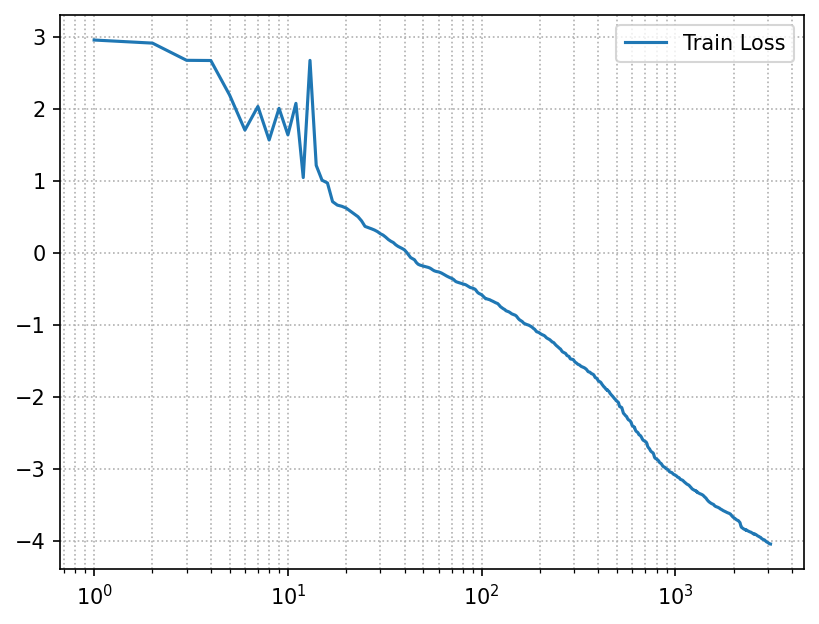

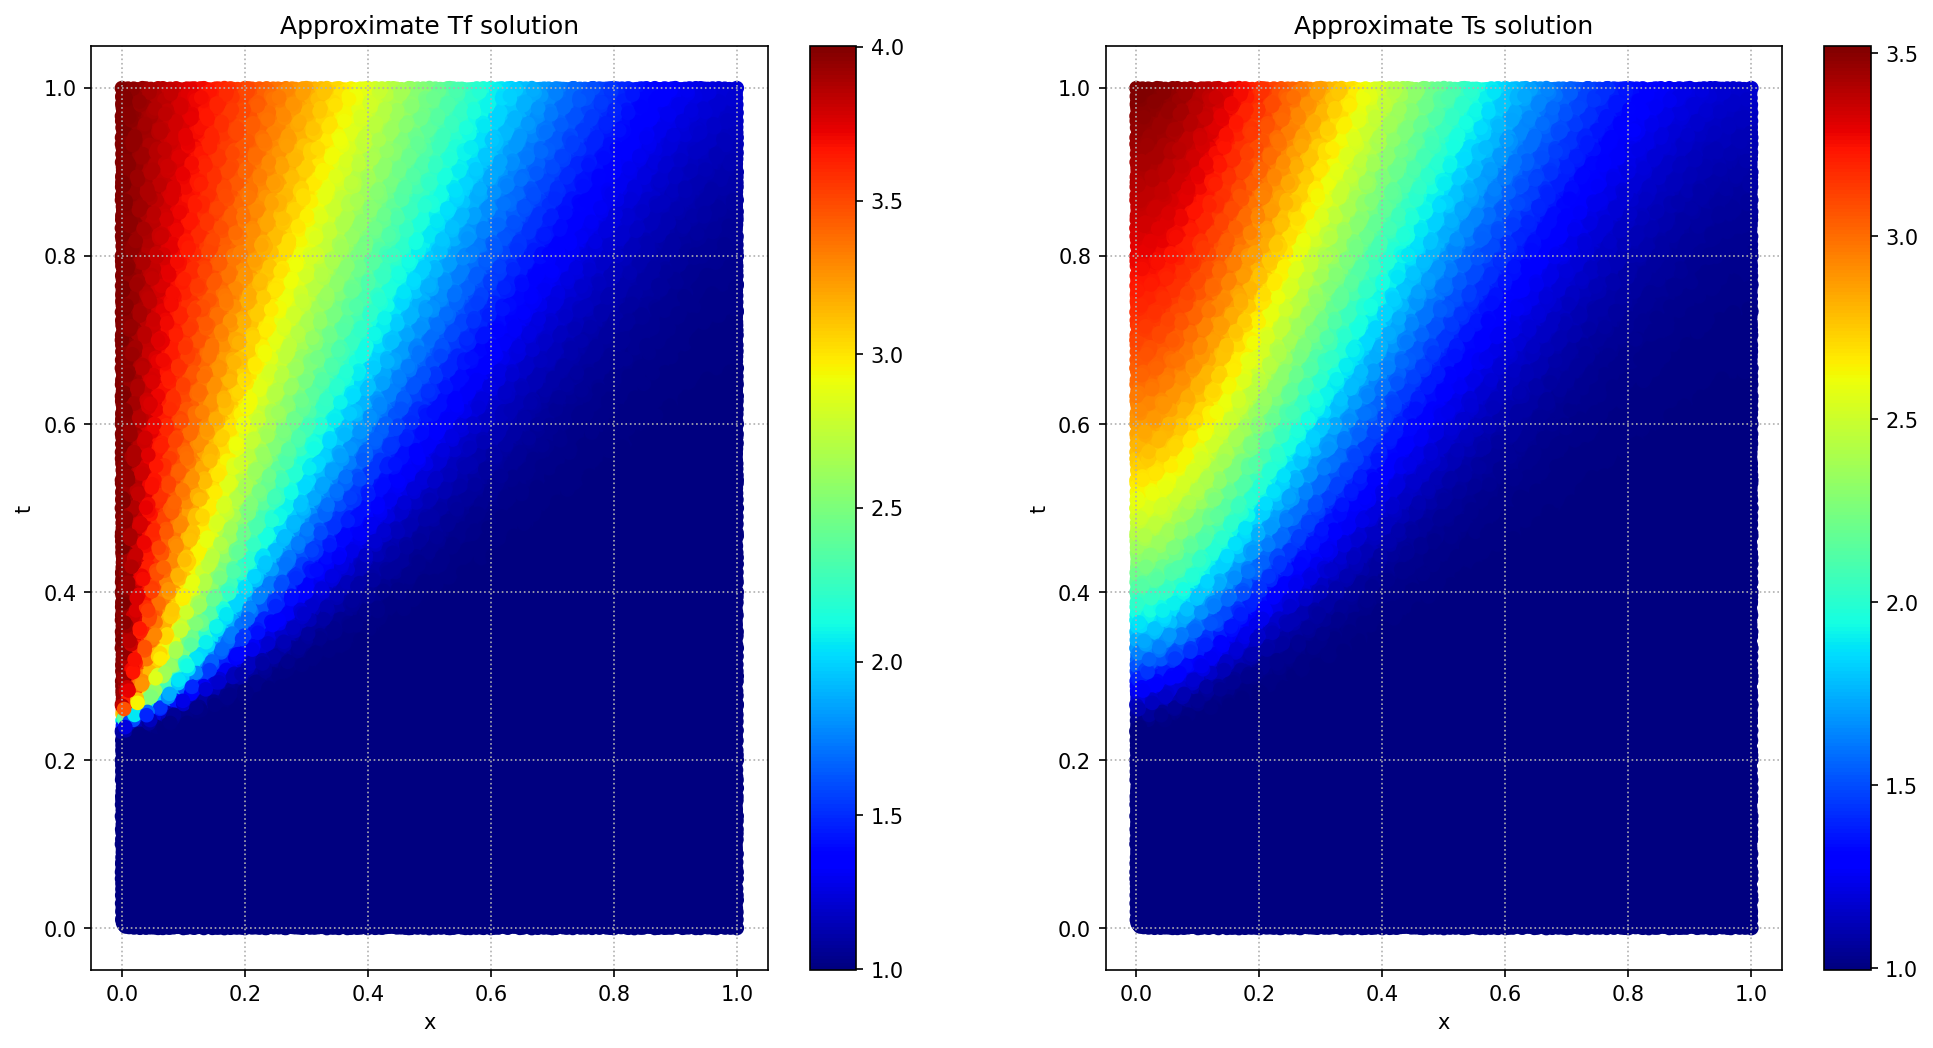

In [29]:
def plot_hist(hist):
    plt.figure(dpi=150)
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
    plt.xscale("log")
    plt.legend()


optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))


if Adam_opt:

    hist_A = pinn.fit(num_epochs=n_epochs_A,
                    optimizer=optimizer_ADAM,
                    verbose=True)
    plot_hist(hist_A)

if LBFGS_opt:
    hist_L = pinn.fit(num_epochs=n_epochs_L,
                    optimizer=optimizer_LBFGS,
                    verbose=True)

    plot_hist(hist_L)

pinn.plotting()

In [31]:

df = pd.read_csv('TestingData.txt')
testing_points = torch.tensor(df[['t', 'x']].values, dtype=torch.float)

output_data= pinn.approximate_solution(testing_points).to('cpu')
testing_points= testing_points.to('cpu')

output_f_np = output_data[:,0].detach().numpy()
output_s_np = output_data[:,1].detach().numpy()

test_df = pd.DataFrame({'t': testing_points[:,0],'x': testing_points[:,1], 'tf': output_f_np, 'ts': output_s_np})
test_df.to_csv(f'Task_1_Regularizer_{Lambda}_hlayers_{Hidden_layers}_N_{Neurons}_FL_{pinn.Final_loss}_Adam_{Adam_opt*n_epochs_A}_LBFGS_{LBFGS_opt*n_epochs_L}.txt',index=False) #save to file
files.download(f'Task_1_Regularizer_{Lambda}_hlayers_{Hidden_layers}_N_{Neurons}_FL_{pinn.Final_loss}_Adam_{Adam_opt*n_epochs_A}_LBFGS_{LBFGS_opt*n_epochs_L}.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>